In [1]:
!pip install torch torchvision torchattacks
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
  Attempting uninstall: requests
    Found existing installation: requ

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchattacks import PGD
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO


In [5]:
# Step 3: Load a pre-trained model (e.g., ResNet)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # Updated for newer torchvision
model.eval()  # Set to evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Step 4: Load the image YOU UPLOADED
image_path = "/content/Giant_Panda_2004-03-2.jpg"  # Using your uploaded file
img = Image.open(image_path)


Original Image:


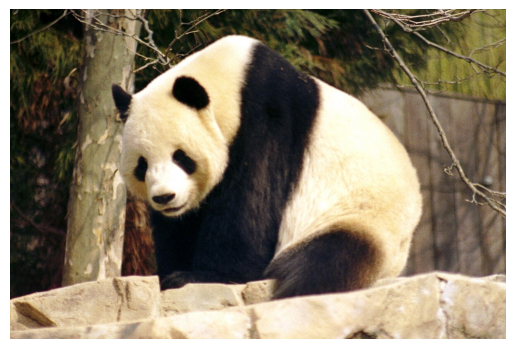

In [9]:
print("Original Image:")
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [10]:
# Preprocess the image for the model
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

In [11]:
# Check the original prediction
with torch.no_grad():
    output = model(img_tensor)
_, predicted = torch.max(output, 1)


In [12]:
# Load ImageNet class labels to decode the prediction
!wget -q https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    classes = [line.strip() for line in f.readlines()]

In [13]:
print(f"Original prediction: {classes[predicted.item()]} (Confidence: {torch.nn.functional.softmax(output, dim=1)[0][predicted].item():.2%})")


Original prediction: giant panda (Confidence: 99.98%)


In [14]:
# Step 5: Perform the adversarial attack
attack = PGD(model, eps=0.03, alpha=0.01, steps=10)
adversarial_image = attack(img_tensor, predicted)


In [15]:
# Check the new prediction
with torch.no_grad():
    adv_output = model(adversarial_image)
_, adv_predicted = torch.max(adv_output, 1)

In [16]:
print(f"Adversarial prediction: {classes[adv_predicted.item()]} (Confidence: {torch.nn.functional.softmax(adv_output, dim=1)[0][adv_predicted].item():.2%})")

Adversarial prediction: mask (Confidence: 99.84%)


In [17]:
# Step 6: Visualize the adversarial image (will look identical to human eyes)
adversarial_image_vis = adversarial_image.squeeze(0).detach().cpu()
adversarial_image_vis = adversarial_image_vis.permute(1, 2, 0).numpy()
adversarial_image_vis = (adversarial_image_vis - adversarial_image_vis.min()) / (adversarial_image_vis.max() - adversarial_image_vis.min()) # Normalize for display

Adversarial Image (looks identical to human):


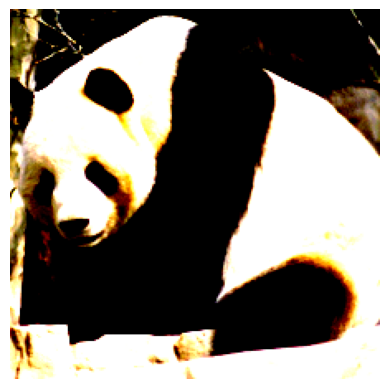

In [18]:
print("Adversarial Image (looks identical to human):")
plt.imshow(adversarial_image_vis)
plt.axis('off')
plt.show()


In [19]:
# Print result
if predicted != adv_predicted:
    print("✅ SUCCESS: Adversarial attack fooled the model!")
    print(f"The model was tricked into seeing a '{classes[adv_predicted.item()]}' instead of a '{classes[predicted.item()]}'.")
else:
    print("❌ Attack failed. Try increasing 'eps' to 0.05 in the PGD attack.")

✅ SUCCESS: Adversarial attack fooled the model!
The model was tricked into seeing a 'mask' instead of a 'giant panda'.
